# Predict Bike Sharing Demand with AutoGluon


##### download Kaggle API key

#### Download the Kaggle dataset using the kaggle python library

#### Install and import packages

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0
    Uninstalling pip-23.0:
      Successfully uninstalled pip-23.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 6.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 716.3 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.4
    Uninstalling wheel-0.38.4:
      Successfully uninstalled wheel-0.38.4
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.6.3
    Uninstalling setuptools-65.6.3:
      Successfully uninstalled setuptools-65.6.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 32.8 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 26.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-a

### Setup Kaggle API Key

In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [34]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "my_Kaggle_username"
kaggle_key = "API_KEY"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [8]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

/usr/bin/sh: 1: kaggle: not found
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [9]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [10]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [11]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [12]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [14]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Train a model using AutoGluon’s Tabular Prediction

* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [15]:
train.drop(columns=['casual', 'registered'], axis=1, inplace=True)

In [16]:
predictor = TabularPredictor(label='count',
                            problem_type='regression',
                            eval_metric='root_mean_squared_error'
                            ).fit(train_data = train,
                                 time_limit = 600,
                                 presets= 'best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240428_080015"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240428_080015/ds_sub_fit/sub_fit_ho.
2024-04-28 08:00:15,615	INFO util.py:154 -- Missing packages: ['ipywidgets']. R

### Review AutoGluon's training run with ranking of models that did the best.

In [17]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.124682  root_mean_squared_error      21.150464  359.188269                0.001153           0.123231            3       True         12
1   RandomForestMSE_BAG_L2  -53.464150  root_mean_squared_error      17.612604  295.575291                0.645544          48.049567            2       True         11
2          LightGBM_BAG_L2  -55.056261  root_mean_squared_error      17.284486  270.422606                0.317426          22.896882            2       True         10
3        LightGBMXT_BAG_L2  -60.390097  root_mean_squared_error      20.186342  288.118589                3.219281          40.592865            2       True          9
4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.077598    0.053402   

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.84979163141213,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble

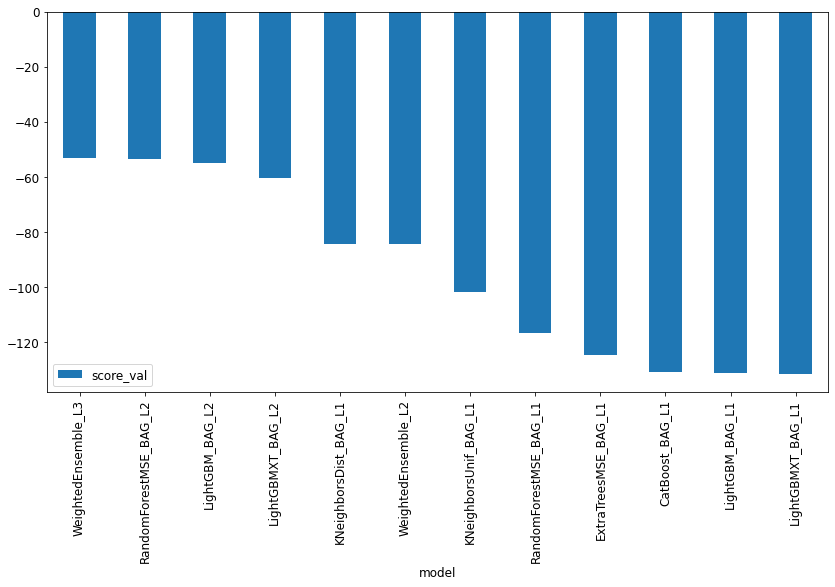

In [130]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.show()

### Create predictions from test dataset

In [18]:
predictions = predictor.predict(test)
predictions.head()

0    22.530865
1    41.817886
2    45.508968
3    48.609322
4    51.710754
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [19]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.386688
std        89.914162
min         2.810693
25%        19.676195
50%        64.157722
75%       168.005188
max       369.828827
Name: count, dtype: float64

In [28]:
# How many negative values do we have?
print("Total Predictions: ", len(predictions))
print("Total Positive Predictions: ", (predictions > 0).sum())
print("Total Negative Predictions: ", (predictions < 0).sum())

Total Predictions:  6493
Total Positive Predictions:  6493
Total Negative Predictions:  0


In [30]:
# Set them to zero
if (predictions < 0).any():
    predictions = predictions[predictions < 0] = 0
    print("All Negative values set to zero")
else:
    print("No Negative value in Predictions")

No Negative value in Predictions


### Set predictions to submission dataframe, save, and submit

In [31]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [38]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 625kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [39]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName            date                 description           status    publicScore  privateScore  
------------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv      2024-04-28 08:42:07  first raw submission  complete  1.80758      1.80758       
submission.csv      2024-04-28 08:41:51  first raw submission  complete  1.80758      1.80758       
submission (2).csv  2024-04-28 08:31:17  First submission      complete  1.80758      1.80758       


#### Initial score of `1.80758`

## Exploratory Data Analysis and Creating additional features

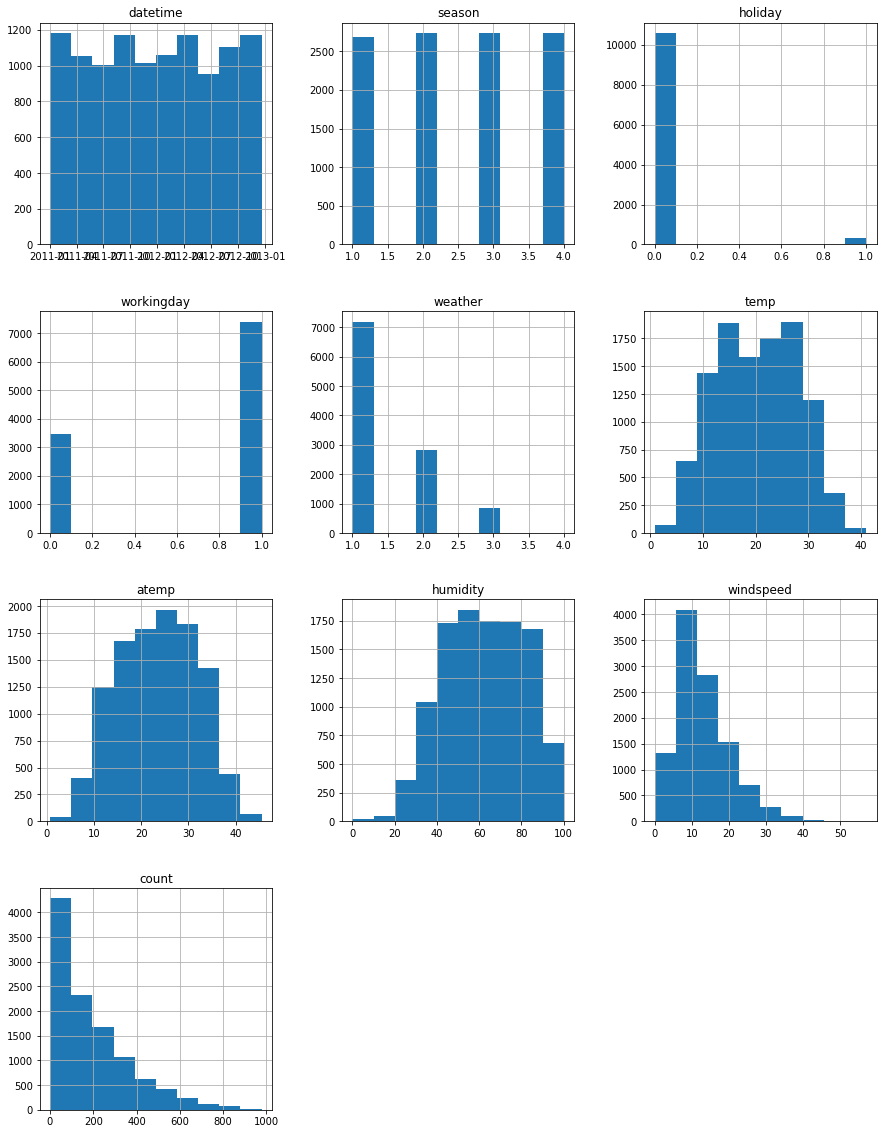

In [41]:
# histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
import matplotlib.pyplot as plt
train.hist(figsize=(15,20))
plt.show()

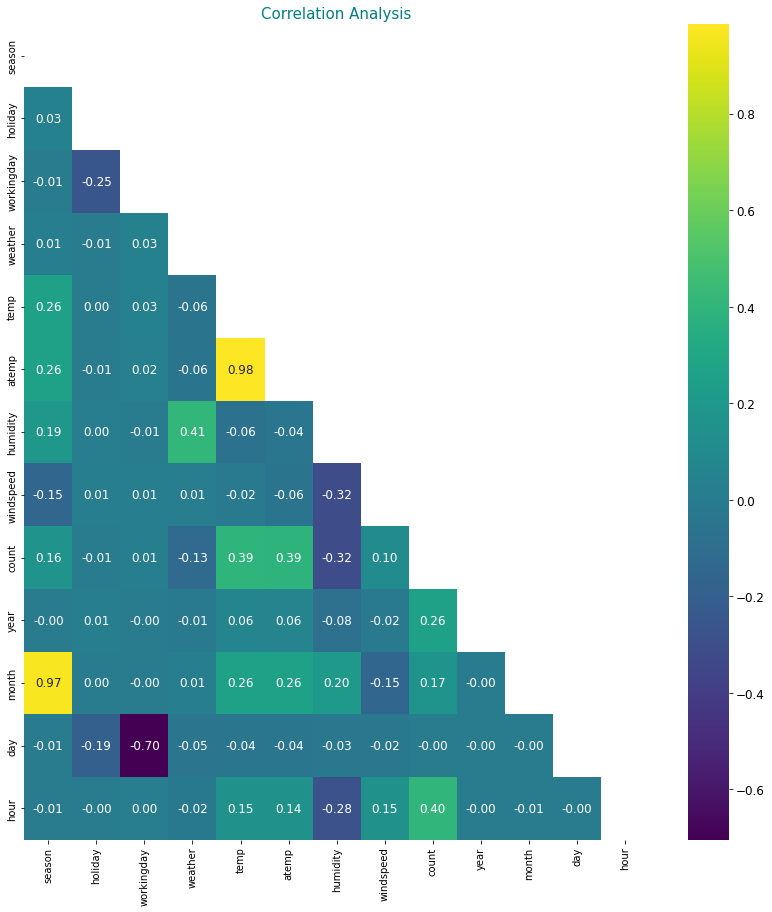

In [124]:
import seaborn as sns
import numpy as np
plt.figure(figsize=(14,15))
corr= train.corr()
mask= np.triu(corr)
plt.title('Correlation Analysis',
         fontsize=15,
         color='teal')
sns.heatmap(corr,
           mask=mask,
           annot=True,
           lw=0,
           linecolor='white',
           cmap='viridis',
           fmt='0.2f')
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [43]:
import datetime
train['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

In [50]:
# create a new training data feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.dayofweek
train['hour'] = train['datetime'].dt.hour
train.drop(columns='datetime', inplace=True)

In [51]:
# create a new test feature
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.dayofweek
test['hour'] = test['datetime'].dt.hour
test.drop(columns='datetime', inplace=True)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [52]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')

test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [53]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,5,4


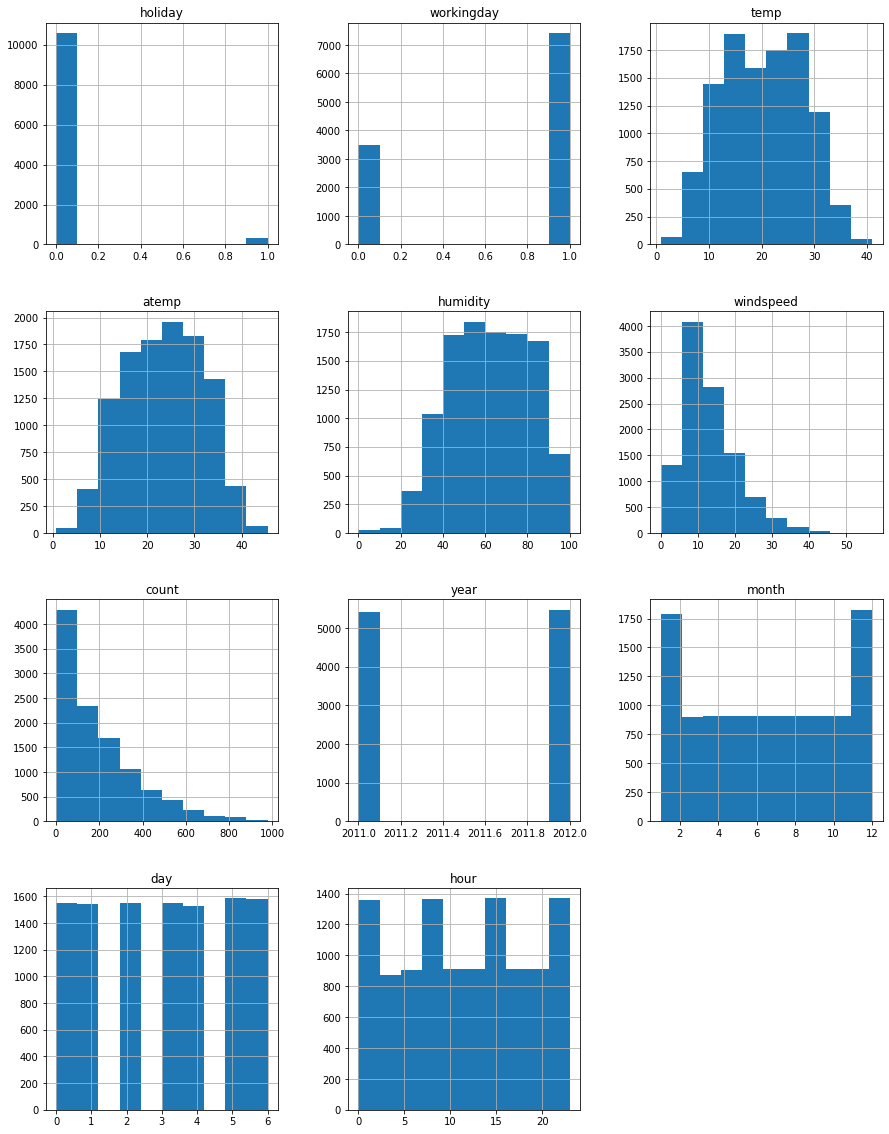

In [55]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))
plt.show()

## Rerun the model with the same settings as before, just with more features

In [56]:
predictor_new_features = TabularPredictor(label='count',
                            problem_type='regression',
                            eval_metric='root_mean_squared_error'
                            ).fit(train_data = train,
                                 time_limit = 600,
                                 presets= 'best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240428_085604"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240428_085604/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 178 seconds

In [57]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -33.956180  root_mean_squared_error      28.789418  370.870140                0.001384           0.051705            3       True         13
1      WeightedEnsemble_L2  -34.238004  root_mean_squared_error      27.245752  263.662553                0.000999           0.055406            2       True          8
2          CatBoost_BAG_L2  -34.263786  root_mean_squared_error      27.687989  303.640088                0.088459          39.934686            2       True         12
3          LightGBM_BAG_L2  -34.546249  root_mean_squared_error      27.738953  283.733005                0.139424          20.027603            2       True         10
4   RandomForestMSE_BAG_L2  -34.787449  root_mean_squared_error      28.560151  310.856145   

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -115.73323148534313,
  'KNeighborsDist_BAG_L1': -112.15711242835349,
  'LightGBMXT_BAG_L1': -36.45988391821316,
  'LightGBM_BAG_L1': -35.79686905713535,
  'RandomForestMSE_BAG_L1': -39.587440921643605,
  'CatBoost_BAG_L1': -36.56421569727163,
  'ExtraTree

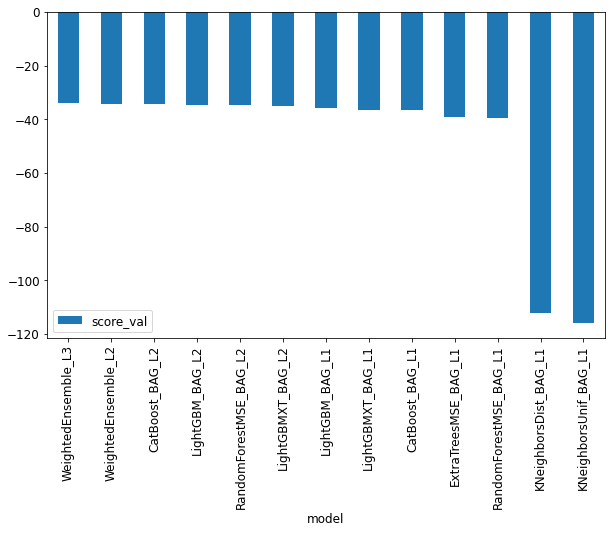

In [135]:
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val", figsize=(10, 6))
plt.show()

In [70]:
new_predictions = predictor_new_features.predict(test)
new_predictions.head()

0    13.798256
1     5.919413
2     4.313587
3     3.517419
4     3.371334
Name: count, dtype: float32

In [75]:
new_predictions.describe()

count    6493.000000
mean      189.904739
std       174.747101
min        -4.830560
25%        45.510422
50%       148.290985
75%       281.622070
max       897.825500
Name: count, dtype: float64

In [78]:
# Set negative values to zero
new_predictions[new_predictions < 0] = 0

# Count the total positive and negative predictions
total_predictions = len(new_predictions)
total_positive_predictions = (new_predictions > 0).sum()
total_negative_predictions = (new_predictions < 0).sum()  # Because we set negatives to zero

print("Total Predictions:", total_predictions)
print("Total Positive Predictions:", total_positive_predictions)
print("Total Negative Predictions:", total_negative_predictions)


Total Predictions: 6493
Total Positive Predictions: 6483
Total Negative Predictions: 0


In [80]:
submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates = ['datetime'])

In [81]:
# Same submitting predictions
submission_new_features["count"] = new_predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [108]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 643kB/s]
Successfully submitted to Bike Sharing Demand

In [109]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-04-28 10:41:30  new features                       complete  0.46268      0.46268       
submission_new_hpo.csv       2024-04-28 10:38:35  new features with hyperparameters  complete  0.5415       0.5415        
submission_new_hpo.csv       2024-04-28 10:11:45  new features with hyperparameters  complete  0.54983      0.54983       
submission_new_features.csv  2024-04-28 09:56:05  new feature                        complete  0.46268      0.46268       


#### New Score of `0.462`

## Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [99]:
import autogluon.core as ag
## From autogluon documentation

# hyperparameters of models
hyperparameters = {'GBM':[{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},'GBMLarge']}

hyperparameter_tune_kwargs = { 
    'num_trials': 20,
    'scheduler' : 'local',
    'searcher': 'auto',
}

predictor_new_hpo = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                    ).fit(train_data=train, 
                                          time_limit=600,
                                          presets="optimize_for_deployment", 
                                          hyperparameters=hyperparameters, 
                                          hyperparameter_tune_kwargs={ 
                                          'num_trials': 20,
                                          'scheduler' : 'local',
                                          'searcher': 'auto'}
                                            )

No path specified. Models will be saved in: "AutogluonModels/ag-20240428_102940"
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240428_102940"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.8.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
CPU Count:          2
Memory Avail:       1.51 GB / 3.78 GB (40.0%)
Disk Space Avail:   8589934589.88 GB / 8589934592.00 GB (100.0%)
Train Data Rows:    10886
Train Data Columns: 12
Label Column:       count
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1549.99 MB
	Train Data (Original)  Memory Usage: 0.69 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. S

[1000]	valid_set's rmse: 40.405
[2000]	valid_set's rmse: 39.1724
[3000]	valid_set's rmse: 38.999
[4000]	valid_set's rmse: 38.9087


  5%|▌         | 1/20 [00:09<03:00,  9.48s/it]

[1000]	valid_set's rmse: 40.9811
[2000]	valid_set's rmse: 40.0977


 10%|█         | 2/20 [00:24<03:44, 12.48s/it]

[1000]	valid_set's rmse: 40.8436
[2000]	valid_set's rmse: 39.525
[3000]	valid_set's rmse: 39.229
[4000]	valid_set's rmse: 39.1728
[5000]	valid_set's rmse: 39.1791


 15%|█▌        | 3/20 [00:43<04:25, 15.60s/it]

[1000]	valid_set's rmse: 75.1181
[2000]	valid_set's rmse: 57.0086
[3000]	valid_set's rmse: 50.2572
[4000]	valid_set's rmse: 46.6284
[5000]	valid_set's rmse: 44.2687
[6000]	valid_set's rmse: 42.7848
[7000]	valid_set's rmse: 41.7234
[8000]	valid_set's rmse: 40.9458
[9000]	valid_set's rmse: 40.3953
[10000]	valid_set's rmse: 40.027


 20%|██        | 4/20 [01:28<07:15, 27.24s/it]

[1000]	valid_set's rmse: 40.5095
[2000]	valid_set's rmse: 39.6514
[3000]	valid_set's rmse: 39.6299
[4000]	valid_set's rmse: 39.7562


 25%|██▌       | 5/20 [01:42<05:35, 22.37s/it]

[1000]	valid_set's rmse: 48.7876
[2000]	valid_set's rmse: 42.014
[3000]	valid_set's rmse: 39.9368
[4000]	valid_set's rmse: 39.2554
[5000]	valid_set's rmse: 38.999
[6000]	valid_set's rmse: 38.8781
[7000]	valid_set's rmse: 38.8591
[8000]	valid_set's rmse: 38.8534


 30%|███       | 6/20 [02:20<06:28, 27.78s/it]

[1000]	valid_set's rmse: 40.389
[2000]	valid_set's rmse: 39.8654


 35%|███▌      | 7/20 [02:32<04:54, 22.63s/it]

[1000]	valid_set's rmse: 40.0652
[2000]	valid_set's rmse: 39.4282
[3000]	valid_set's rmse: 39.4447


 40%|████      | 8/20 [02:41<03:40, 18.37s/it]

[1000]	valid_set's rmse: 66.7978
[2000]	valid_set's rmse: 51.4122
[3000]	valid_set's rmse: 46.0648
[4000]	valid_set's rmse: 43.3709
[5000]	valid_set's rmse: 41.7836
[6000]	valid_set's rmse: 40.7804
[7000]	valid_set's rmse: 40.1431
[8000]	valid_set's rmse: 39.7364
[9000]	valid_set's rmse: 39.4472
[10000]	valid_set's rmse: 39.2571


 45%|████▌     | 9/20 [03:32<05:13, 28.48s/it]

[1000]	valid_set's rmse: 41.2208
[2000]	valid_set's rmse: 40.9148


 50%|█████     | 10/20 [03:41<03:45, 22.52s/it]

[1000]	valid_set's rmse: 55.2933
[2000]	valid_set's rmse: 45.0742
[3000]	valid_set's rmse: 41.8163
[4000]	valid_set's rmse: 40.4675
[5000]	valid_set's rmse: 39.7137
[6000]	valid_set's rmse: 39.3188
[7000]	valid_set's rmse: 39.0969
[8000]	valid_set's rmse: 38.9548
[9000]	valid_set's rmse: 38.9075
[10000]	valid_set's rmse: 38.8621


	Stopping HPO to satisfy time limit...
 50%|█████     | 10/20 [04:33<04:33, 27.32s/it]
Fitted model: LightGBMXT/T1 ...
	-38.8821	 = Validation score   (-root_mean_squared_error)
	7.54s	 = Training   runtime
	1.21s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-40.0557	 = Validation score   (-root_mean_squared_error)
	9.61s	 = Training   runtime
	3.47s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-39.1338	 = Validation score   (-root_mean_squared_error)
	15.18s	 = Training   runtime
	2.58s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	-40.0268	 = Validation score   (-root_mean_squared_error)
	28.16s	 = Training   runtime
	12.52s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	-39.6171	 = Validation score   (-root_mean_squared_error)
	10.78s	 = Training   runtime
	1.82s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	-38.8376	 = Validation score   (-root_mean_squared_error)
	25.24s	 = Training   runtime
	8.91s	 = Validation runtime
Fitted model: 

[1000]	valid_set's rmse: 38.5198


	-38.3822	 = Validation score   (-root_mean_squared_error)
	3.88s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 247.16s of remaining time.
	Ensemble Weights: {'LightGBMLarge': 0.52, 'LightGBMXT/T6': 0.32, 'LightGBMXT/T3': 0.12, 'LightGBMXT/T1': 0.04}
	-36.8759	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 353.13s ... Best model: "WeightedEnsemble_L2"
Deleting model LightGBMXT/T2. All files under AutogluonModels/ag-20240428_102940/models/LightGBMXT/T2 will be removed.
Deleting model LightGBMXT/T4. All files under AutogluonModels/ag-20240428_102940/models/LightGBMXT/T4 will be removed.
Deleting model LightGBMXT/T5. All files under AutogluonModels/ag-20240428_102940/models/LightGBMXT/T5 will be removed.
Deleting model LightGBMXT/T7. All files under AutogluonModels/ag-20240428_102940/models/LightGBMXT/T7 

In [100]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -36.875898  root_mean_squared_error      13.082497  51.847283                0.000673           0.021348            2       True          5
1        LightGBMLarge -38.382190  root_mean_squared_error       0.385435   3.875176                0.385435           3.875176            1       True          4
2        LightGBMXT/T6 -38.837610  root_mean_squared_error       8.907654  25.235186                8.907654          25.235186            1       True          3
3        LightGBMXT/T1 -38.882119  root_mean_squared_error       1.211308   7.537246                1.211308           7.537246            1       True          1
4        LightGBMXT/T3 -39.133756  root_mean_squared_error       2.577428  15.178326                2.577428          15.17

{'model_types': {'LightGBMXT/T1': 'LGBModel',
  'LightGBMXT/T3': 'LGBModel',
  'LightGBMXT/T6': 'LGBModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT/T1': -38.882118545703165,
  'LightGBMXT/T3': -39.1337559445348,
  'LightGBMXT/T6': -38.83760950495497,
  'LightGBMLarge': -38.382190280507615,
  'WeightedEnsemble_L2': -36.875897728492},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMXT/T1': ['LightGBMXT', 'T1'],
  'LightGBMXT/T3': ['LightGBMXT', 'T3'],
  'LightGBMXT/T6': ['LightGBMXT', 'T6'],
  'LightGBMLarge': ['LightGBMLarge'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2']},
 'model_fit_times': {'LightGBMXT/T1': 7.537246465682983,
  'LightGBMXT/T3': 15.178325891494751,
  'LightGBMXT/T6': 25.235185861587524,
  'LightGBMLarge': 3.875176429748535,
  'WeightedEnsemble_L2': 0.021348237991333008},
 'model_pred_times': {'LightGBMXT/T1': 1.2113075256347656,
  'LightGBMXT/T3': 2.5774283409118652,
  'L

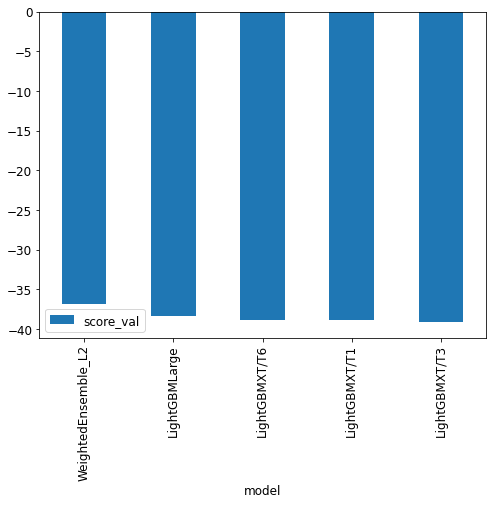

In [133]:
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val", figsize=(8, 6))
plt.show()

In [101]:
hypo_predictions = predictor_new_hpo.predict(test)
hypo_predictions.head()

0    15.880662
1     5.437002
2     3.183892
3     1.323320
4     2.083238
Name: count, dtype: float32

In [102]:
len(hypo_predictions)

6493

In [103]:
# Set negative values to zero
hypo_predictions[hypo_predictions < 0] = 0

# Count the total positive and negative predictions
total_predictions = len(hypo_predictions)
total_positive_predictions = (hypo_predictions > 0).sum()
total_negative_predictions = (hypo_predictions < 0).sum()  # Because we set negatives to zero

print("Total Predictions:", total_predictions)
print("Total Positive Predictions:", total_positive_predictions)
print("Total Negative Predictions:", total_negative_predictions)


Total Predictions: 6493
Total Positive Predictions: 6390
Total Negative Predictions: 0


In [104]:
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])

In [105]:
# Same submitting predictions
submission_new_hpo["count"] = hypo_predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [106]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 546kB/s]
Successfully submitted to Bike Sharing Demand

In [107]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-04-28 10:38:35  new features with hyperparameters  complete  0.5415       0.5415        
submission_new_hpo.csv       2024-04-28 10:11:45  new features with hyperparameters  complete  0.54983      0.54983       
submission_new_features.csv  2024-04-28 09:56:05  new feature                        complete  0.46268      0.46268       
submission.csv               2024-04-28 08:42:07  first raw submission               complete  1.80758      1.80758       


#### New Score of `0.5415`

## Project Report
### Refer to the markdown file for the full report
### Creating plots and table for report

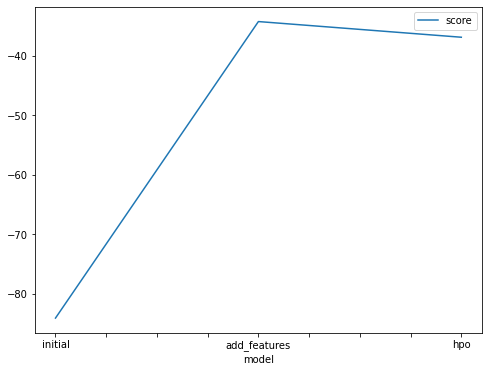

In [113]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-84.125061, -34.238004, -36.875898]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

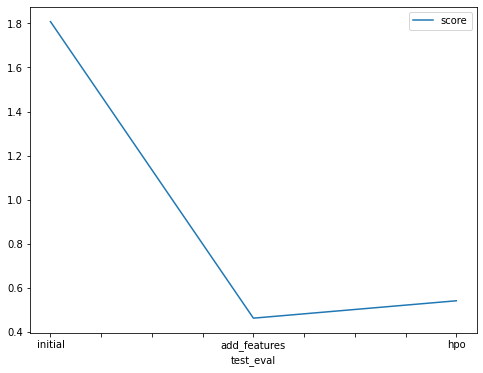

In [114]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80758, 0.46268, 0.5415]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [116]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['default_params', 'default_params', 'GBM: num_leaves: lower=26, upper=66'],
    "hpo2": ['default_params', 'default_params', 'NN: dropout_prob: 0.0, 0.5'],
    "hpo3": ['default_params', 'default_params', 'GBM: num_boost_round: 100'],
    "score": [1.80758, 0.46268, 0.5415]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default_params,default_params,default_params,1.80758
1,add_features,default_params,default_params,default_params,0.46268
2,hpo,"GBM: num_leaves: lower=26, upper=66","NN: dropout_prob: 0.0, 0.5",GBM: num_boost_round: 100,0.54150


## Summary:
The best perfomed model is `predictor_new_features` (model with new features) with RMSE Score of 0.46268